<a href="https://colab.research.google.com/github/Raahee1729/PyCBC-Tuts-and-Examples/blob/main/Signal_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is for, MATHCED FILTERING :-

1. capring H1 and L1 data putting it in for loop
2.

In [ ]:
# Install PyCBC and downgrade NumPy
!pip install -q numpy==1.23.5
!pip install -q pycbc

# Restart the runtime to finalize NumPy change
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 96.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.1

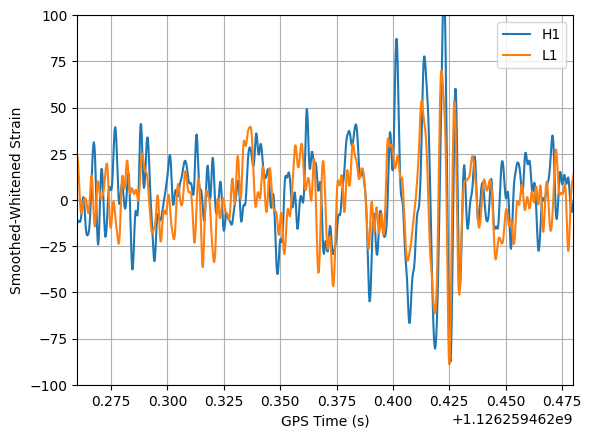

In [ ]:
%matplotlib inline
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.psd import welch, interpolate
import pylab

from pycbc.catalog import Merger

for ifo in ['H1', 'L1']:                                               # In this loop everything is interated twice first from ifo=H1 and then for ifo=L1,
                                                                       # Read data: The data is available to the public through losc.ligo.org!


    ts = Merger("GW150914").strain(ifo)                                # event (this) and with strain data of the (ifo=H1 or ifo=L1)


    psd = interpolate(welch(ts), 1.0 / ts.duration)                          # Estimate the noise spectrum and use it to whiten the data

    white_strain = (ts.to_frequencyseries() / psd ** 0.5).to_timeseries()    # time series into freq domain, taking the square root of PSD to get ASD
                                                                             # devide the freq domain dta by ASD and convert back the whitened data in time domain

    # remove frequencies below and above where the main portion of the signal lies
    smooth = highpass_fir(white_strain, 35, 8)
    smooth = lowpass_fir(smooth, 300, 8)

    # time shift and flip L1 to match the time of arrival and phase of Hanford
    #to align the Livingston data in phase and arrival time with Hanford, since signals arrive at the two sites at slightly different times and phases
    if ifo == 'L1':
        smooth *= -1                                # to flit the signal 180 degree to match with H1
        smooth.roll(int(.007 / smooth.delta_t))     #To align the Livingston (L1) signal in time with Hanford (H1) by shifting it forward by 7 milliseconds

    pylab.plot(smooth.sample_times.numpy(), smooth.numpy(), label=ifo)      # plotting

# Plot the region around the signal (time is in gps seconds)
pylab.legend()
pylab.xlim(1126259462.26, 1126259462.48)
pylab.ylabel('Smoothed-Whitened Strain')
pylab.grid()
pylab.ylim(-100, 100)
pylab.xlabel('GPS Time (s)')
pylab.show()

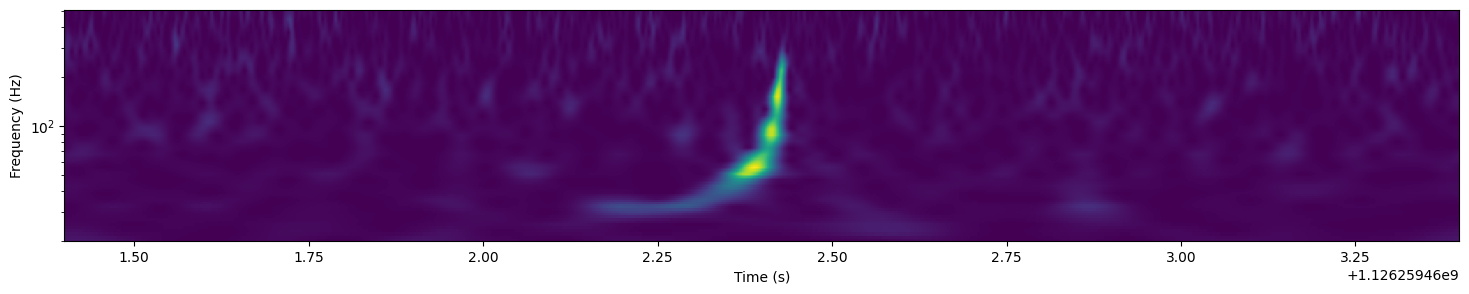

In [ ]:
ts = Merger("GW150914").strain("H1")

ts = ts.whiten(4, 4)
zoom = ts.time_slice(1126259462.4 - 1, 1126259462.4 + 1)
times, freqs, power = zoom.qtransform(.001, 1, frange=(20, 512), qrange=(4, 64))

pylab.figure(figsize=(18, 3))
pylab.pcolormesh(times, freqs, power)
pylab.ylim(20, 512)
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(times.min(), times.max())
pylab.yscale('log')